In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder

from scipy.stats import chi2_contingency

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential 
from keras.layers import Dense
from keras.initializers import GlorotUniform
from keras.initializers import HeUniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.metrics import Precision, Recall

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK

#ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

TEST_SIZE = 0.2



2024-09-26 20:26:26.564001: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 20:26:26.564040: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 20:26:26.564075: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 20:26:26.571638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-------------------------


In [15]:
# Import del dataset e divisione in train e test
train_df = pd.read_csv('datasets/SpaceshipTitanic.csv')

# Viene diviso il train set in train e validation set
train, test_df = train_test_split(train_df, test_size = TEST_SIZE, random_state = 42)
train_df, val_df = train_test_split(train, test_size = TEST_SIZE, random_state = 42)

train_x = train_df.iloc[:,:-1]
train_y = train_df.iloc[:,-1].astype(float)

val_x = val_df.iloc[:,:-1]
val_y = val_df.iloc[:,-1].astype(float)

test_x = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,-1].astype(float)

In [3]:
# Funzione per calcolare la dipendenza tra feature categoriche con il chi-square test.
# Il test ha come ipotesi nulla che le due variabili siano indipendenti. Quindi con un p-value
# minore di 0.05 si rigetta l'ipotesi nulla e si accetta che le due variabili sono dipendenti.
def chi_square(f1, f2):
    crosstab_result=pd.crosstab(index=f1,columns=f2)
    return chi2_contingency(crosstab_result)[1]

In [4]:
# Home_planet
# Si nota la forte correlazione tra group ed home planet/destination e quindi per i nan si possono assegnre i valori del gruppo. 
# Restano problematici i gruppi composti da una sola persona, si introduce quindi una nuova categoria di home planet e destination 
# per persona con origine o destinazione sconosciuta.

def mv_hp_d(dataset):
    print("-------------------------- HomePlanet -------------------------")

    # HomePlanet
    p = chi_square(dataset['HomePlanet'], dataset['Group'])
    print(f"Le feature HomePlanet e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                           else "Le feature Destination e Group non sono correlate")

    print(f"Numero di persone con HomePlanet nullo: {str(dataset['HomePlanet'].isna().sum())}")
    dataset['HomePlanet'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['HomePlanet'][(dataset['Solo']==1)] = dataset[(dataset['Solo']==1)].groupby('Group')['HomePlanet'].transform(lambda x: x.fillna("unknown"))
    print(f"Numero di persone con HomePlanet nullo: {str(dataset['HomePlanet'].isna().sum())}")

    # Destination
    print("-------------------------- Destination ------------------------")
    p = chi_square(dataset['Destination'], dataset['Group'])
    print(f"Le feature Destination e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                           else "Le feature Destination e Group non sono correlate")
    
    print(f"Numero di persone con Destination nullo: {str(dataset['Destination'].isna().sum())}")
    dataset['Destination'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['Destination'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['Destination'][(dataset['Solo']==1)] = dataset[(dataset['Solo']==1)].groupby('Group')['Destination'].transform(lambda x: x.fillna("unknown"))
    print(f"Numero di persone con Destination nullo: {str(dataset['Destination'].isna().sum())}")

# Age
# Si distinguono 3 casi di persone con Age nullo: persone sole, persone con famiglia che non spendono e persone con famiglia che spendono.
# Per assegnare l'età si usa la mediana del caso di appartenenza, immaginando che è meno probabile che una persona sola sia un bambino
# e che al contrario è più probabile che una persona che non spende, ma è in un gruppo lo sia.
def mv_age(dataset):
    print("----------------------------- Age -----------------------------")
    solo = dataset['Solo']==1
    family_no_spending = (dataset['Family_size']>1) & (dataset['No_spending']==1)
    family_spending = (dataset['Family_size']>1) & (dataset['No_spending']==0)
    
    print(f"Numero di persone con Age nullo: {str(dataset['Age'].isna().sum())}, di cui:")
    print(f"Persone sole: {str(dataset['Age'][solo].isna().sum())}")
    print(f"Persone con famiglia che non spendono: {str(dataset['Age'][family_no_spending].isna().sum())}")   
    print(f"Persone con famiglia che spendono: {str(dataset['Age'][family_spending].isna().sum())}")

    dataset['Age'][solo] = dataset[solo]['Age'].transform(lambda x: x.fillna(dataset[solo]['Age'].median()))
    dataset['Age'][family_no_spending] = dataset[family_no_spending]['Age'].transform(lambda x: x.fillna(dataset[family_no_spending]['Age'].median()))
    dataset['Age'][family_spending] = dataset[family_spending]['Age'].transform(lambda x: x.fillna(dataset[family_spending]['Age'].median()))

    print(f"Numero di persone con Age nullo: {str(dataset['Age'].isna().sum())}")   


# Surname
# Si osserva che i gruppi sono per gran parte composti da persone con lo stesso cognome, quindi si può assegnare la moda del cognome del gruppo
# alle persone con cognome nullo. Per i gruppi composti da una sola persona si assegna cognome 'unknown'.
def mv_surname(dataset):
    print("------------------------------ Surname ------------------------")

    p = chi_square(dataset['Surname'], dataset['Group'])
    print(f"Le feature Surname e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                       else "Le feature Surname e Group non sono correlate")

    print(f"Numero di persone con Surname nullo: {str(dataset['Surname'].isna().sum())}")
    dataset['Surname'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['Surname'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['Surname'][(dataset['Solo']==1)] = dataset[(dataset['Solo']==1)].groupby('Group')['Surname'].transform(lambda x: x.fillna("Unknown"))
    print(f"Numero di persone con Surname nullo: {str(dataset['Surname'].isna().sum())}")

# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
# Si sostituiscono i valori nulli con la media di spesa delle altre categorie non nulle, dopo aver osservato che ogni persona ha almeno un valore
# di spesa non nullo. Ad esempio, se una persona ha spesa nulla per RoomService e ShoppingMall, ma ha spesa per FoodCourt e Spa, si assegna la media
# di FoodCourt e Spa per RoomService e ShoppingMall.
def mv_exp(dataset):
    print("------ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck ------")
    print(f"Persone con servizi nulli: {str(dataset[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isnull().any(axis=1).sum())}")
    # Per ogni persona con almeno un servizio nullo, si calcola la media delle spese non nulle
    dataset['RoomService'] = dataset['RoomService'].fillna(dataset[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1))
    dataset['FoodCourt'] = dataset['FoodCourt'].fillna(dataset[['RoomService', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1))
    dataset['ShoppingMall'] = dataset['ShoppingMall'].fillna(dataset[['RoomService', 'FoodCourt', 'Spa', 'VRDeck']].mean(axis=1))
    dataset['Spa'] = dataset['Spa'].fillna(dataset[['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck']].mean(axis=1))
    dataset['VRDeck'] = dataset['VRDeck'].fillna(dataset[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa']].mean(axis=1))
    print(f"Persone con servizi nulli: {str(dataset[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isnull().any(axis=1).sum())}")

# Controllare se i gruppi hanno tutti lo stesso valore di cabin_side
def mv_cabins(dataset):
    print("------------------------- Cabin_side --------------------------")
    p = chi_square(dataset['Cabin_side'], dataset['Group'])
    print(f"Le feature Cabin_side e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                          else "Le feature Cabin_side e Group non sono correlate")
    print(f"Numero di persone con Cabin_side nullo: {str(dataset['Cabin_side'].isna().sum())}")
    dataset['Cabin_side'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['Cabin_side'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['Cabin_side'][(dataset['Solo']==1)] = dataset['Cabin_side'][(dataset['Solo']==1)].fillna('unknown')
    print(f"Numero di persone con Cabin_side nullo: {str(dataset['Cabin_side'].isna().sum())}")

    print("------------------------ Cabin_number -------------------------")
    p = chi_square(dataset['Cabin_number'], dataset['Group'])
    print(f"Le feature Cabin_number e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                            else "Le feature Cabin_number e Group non sono correlate")
    print(f"Numero di persone con Cabin_number nullo: {str(dataset['Cabin_number'].isna().sum())}")
    dataset['Cabin_number'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['Cabin_number'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['Cabin_number'][(dataset['Solo']==1)] = dataset['Cabin_number'][(dataset['Solo']==1)].fillna(0)
    print(f"Numero di persone con Cabin_number nullo: {str(dataset['Cabin_number'].isna().sum())}")
    
    print("------------------------- Cabin_deck --------------------------")
    p = chi_square(dataset['Cabin_deck'], dataset['Group'])
    print(f"Le feature Cabin_deck e Group sono correlate, con p-value{p}" if p < 0.05 \
                                                                               else "Le feature Cabin_deck e Group non sono correlate")
    print(f"Numero di persone con Cabin_deck nullo: {str(dataset['Cabin_deck'].isna().sum())}")
    dataset['Cabin_deck'][(dataset['Solo']==0)] = dataset[(dataset['Solo']==0)].groupby('Group')['Cabin_deck'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset['Cabin_deck'][(dataset['Solo']==1)] = dataset['Cabin_deck'][(dataset['Solo']==1)].fillna('unknown')
    print(f"Numero di persone con Cabin_deck nullo: {str(dataset['Cabin_deck'].isna().sum())}")

# Strategia: VIP, CrioSleep
# Per le feature VIP e CrioSleep si assegna il valore della moda a tutti i valori nulli.
def mv_vip_crio(dataset):
    print("----------------------------- VIP, CryoSleep ------------------")
    print(f"Numero di persone con VIP nullo: {str(dataset['VIP'].isna().sum())}")
    dataset['VIP'] = dataset['VIP'].fillna(dataset['VIP'].mode()[0])
    print(f"Numero di persone con VIP nullo: {str(dataset['VIP'].isna().sum())}")

    print(f"Numero di persone con CryoSleep nullo: {str(dataset['CryoSleep'].isna().sum())}")
    dataset['CryoSleep'] = dataset['CryoSleep'].fillna(dataset['CryoSleep'].mode()[0])
    print(f"Numero di persone con CryoSleep nullo: {str(dataset['CryoSleep'].isna().sum())}")

In [5]:
def preprocess_data(dataset, train=True):
    # Viene aggiunta una colonna per contare il numero di persone nel gruppo di appartenenza e se la persona è da sola
    dataset['Group'] = dataset['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)
    dataset['Group_size']=dataset['Group'].map(lambda x: dataset['Group'].value_counts()[x])
    dataset['Solo']=(dataset['Group_size']==1).astype(int)
    dataset.drop('PassengerId', axis=1, inplace=True)

    # Viene creata una colonna per il cognome e si rimuove la colonna Name
    dataset['Name'].fillna('Unknown Unknown', inplace=True)
    dataset['Surname']=dataset['Name'].str.split().str[-1]
    dataset.loc[dataset['Surname']=='Unknown','Surname']=np.nan
    dataset.drop('Name', axis=1, inplace=True)

    if train:
        # Vengono riempiti i valori nulli delle colonne RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
        mv_exp(dataset)
        # Vengono riempiti i valori nulli della colonna HomePlanet, Destination, Surmane
        mv_hp_d(dataset)
        mv_surname(dataset)
    
    # Vengono prese tutte le colonne che rappresentano le spese e si aggiunge una colonna per contare il
    # totale speso dalla persona e una colonna booleana per indicare se la persona non ha speso nulla
    exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    dataset['Expenditure']=dataset[exp_feats].sum(axis=1)
    dataset['No_spending']=(dataset['Expenditure']==0).astype(int)

    # Viene aggiunta una colonna per contare le persone che hanno lo stesso cognome
    dataset['Family_size']=dataset[(dataset['Surname']!='Unknown')].groupby('Group')['Surname'].transform('count')
    dataset.loc[dataset['Surname']=='Unknown','Family_size']=1
    dataset.loc[dataset['Family_size']>100,'Family_size']=np.nan
    dataset.drop('Surname', axis=1, inplace=True)

    # Separazione della colonna 'Cabin' nelle colonne deck, number e side
    dataset['Cabin'].fillna('Z/9999/Z', inplace=True)

    dataset['Cabin_deck'] = dataset['Cabin'].apply(lambda x: x.split('/')[0])
    dataset['Cabin_number'] = dataset['Cabin'].apply(lambda x: x.split('/')[1]).astype(int)
    dataset['Cabin_side'] = dataset['Cabin'].apply(lambda x: x.split('/')[2])

    dataset.loc[dataset['Cabin_deck']=='Z', 'Cabin_deck']=np.nan
    dataset.loc[dataset['Cabin_number']==9999, 'Cabin_number']=np.nan
    dataset.loc[dataset['Cabin_side']=='Z', 'Cabin_side']=np.nan

    dataset.drop('Cabin', axis=1, inplace=True)
    if train:
        # Vengono riempiti i valori nulli della colonna Age
        mv_age(dataset)
        mv_cabins(dataset)
        mv_vip_crio(dataset)
        dataset['VIP'].astype(object)
        dataset['CryoSleep'].astype(object)

    # Viene aggiunta una colonna che assegna ogni passeggero al gruppo di età di appartenenza
    dataset['Age_group']=0
    dataset.loc[dataset['Age']<=12,'Age_group']='Age_0-12'
    dataset.loc[(dataset['Age']>12) & (dataset['Age']<18),'Age_group']='Age_13-17'
    dataset.loc[(dataset['Age']>=18) & (dataset['Age']<=25),'Age_group']='Age_18-25'
    dataset.loc[(dataset['Age']>25) & (dataset['Age']<=30),'Age_group']='Age_26-30'
    dataset.loc[(dataset['Age']>30) & (dataset['Age']<=50),'Age_group']='Age_31-50'
    dataset.loc[dataset['Age']>50,'Age_group']='Age_51+'

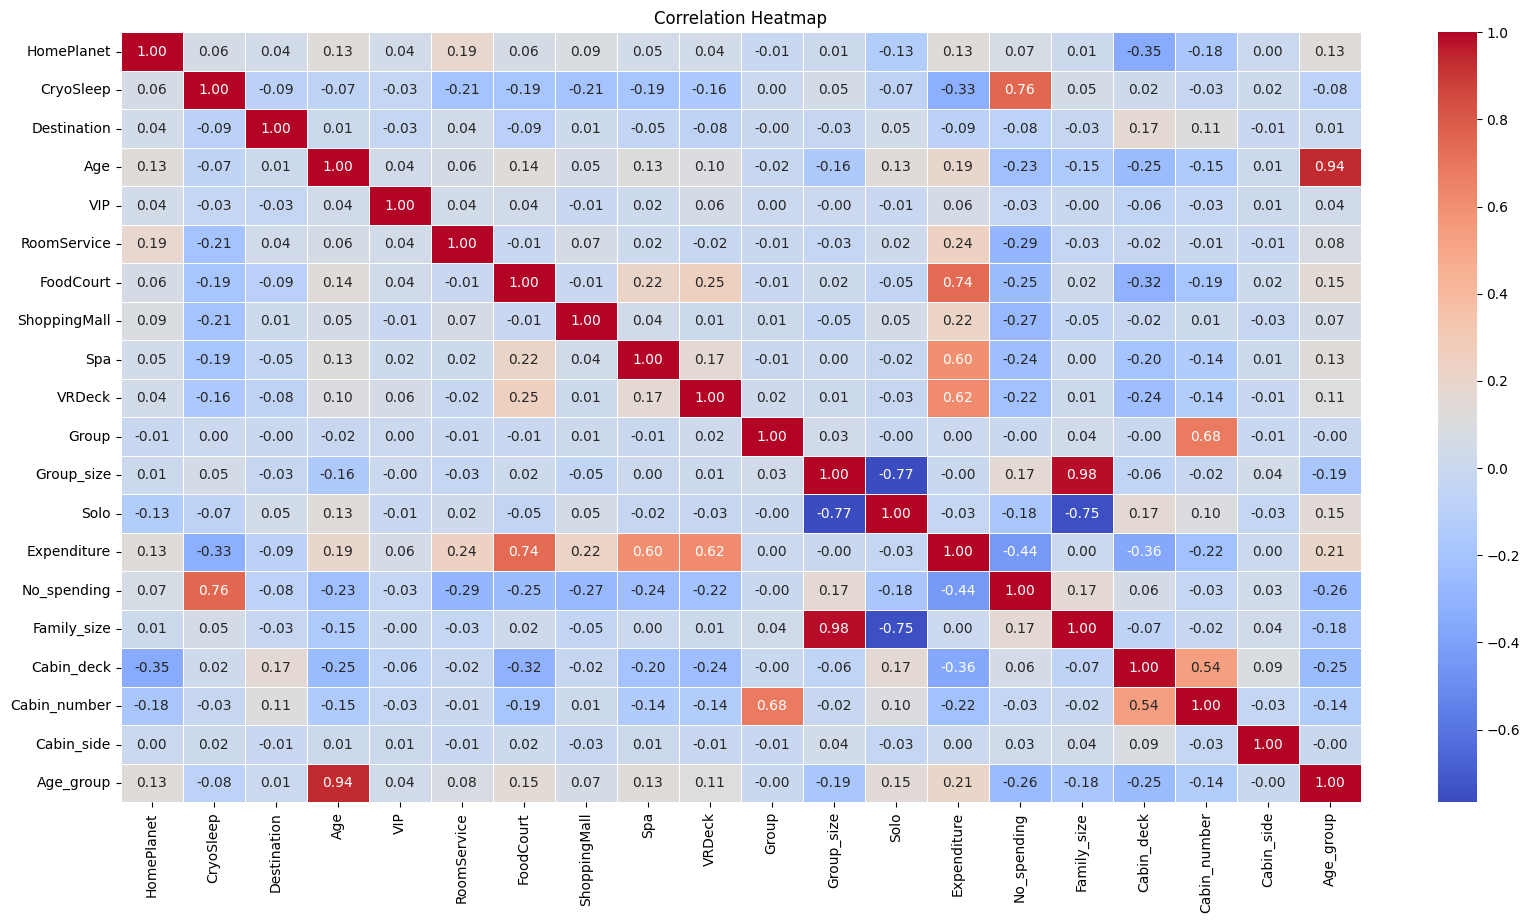

In [6]:
hm_set = train_x.copy()
preprocess_data(hm_set, False)
# Seleziona le colonne numeriche e categoriali
hm_set = hm_set.apply(lambda col: col.astype(str) if col.dtype == 'object' else col)
num_cols = hm_set.select_dtypes(exclude='object').columns
cat_cols = hm_set.select_dtypes(include='object').columns

# Applica lo scaling ai dati numerici
scaler = StandardScaler()
hm_set[num_cols] = scaler.fit_transform(hm_set[num_cols])

# Applica l'encoding ai dati categoriali
encoder = OrdinalEncoder()
hm_set[cat_cols] = encoder.fit_transform(hm_set[cat_cols])

correlation_matrix=hm_set.corr()
correlation_matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



In [7]:
def encoding(dataset, ord_list):
    # Chiamata al preprocessing
    preprocess_data(dataset)

    # Crea un dizionario con indici le colonne originali e valori la media della colonna se colonna numerica o la moda se colonna categorica
    fill_dict = {col: dataset[col].mean() if dataset[col].dtype != 'object' else dataset[col].mode()[0] for col in dataset.columns}

    # Seleziona le colonne numeriche e categoriali
    num_cols = dataset.select_dtypes(exclude=['object', 'bool']).columns.difference(ord_list)
    cat_cols = dataset.select_dtypes(include=['object', 'bool']).columns.difference(ord_list)
    print(train_x.dtypes)
    # Applica lo scaling ai dati numerici
    scaler = StandardScaler()
    dataset[num_cols] = scaler.fit_transform(dataset[num_cols])

    # Applica l'encoding ai dati categoriali nella lista ord_list
    encoder = OrdinalEncoder()
    dataset[ord_list] = encoder.fit_transform(dataset[ord_list])

    # Applica l'encoding ai dati categoriali che non sono nella lista ord_list
    dataset = pd.get_dummies(dataset, columns=cat_cols)

    return dataset.astype(float), fill_dict, scaler, encoder


ord_list = ['Cabin_number']
train_x, mean, scaler, encoder = encoding(train_x, ord_list)



------ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck ------
Persone con servizi nulli: 561
Persone con servizi nulli: 0
-------------------------- HomePlanet -------------------------
Le feature HomePlanet e Group sono correlate, con p-value3.8934366240285363e-59
Numero di persone con HomePlanet nullo: 133
Numero di persone con HomePlanet nullo: 0
-------------------------- Destination ------------------------
Le feature Destination e Group sono correlate, con p-value0.010566808288315032
Numero di persone con Destination nullo: 113
Numero di persone con Destination nullo: 0
------------------------------ Surname ------------------------
Le feature Surname e Group sono correlate, con p-value0.0
Numero di persone con Surname nullo: 132
Numero di persone con Surname nullo: 0
----------------------------- Age -----------------------------
Numero di persone con Age nullo: 116, di cui:
Persone sole: 73
Persone con famiglia che non spendono: 33
Persone con famiglia che spendono: 10
Numero

In [8]:
import os
str_path = 'objects/features_titanic.npy'
def fs(dataset, dataset_y):
    #controllare se esiste il file features.npy
    if not os.path.exists(str_path):
        dataset['Survived'] = dataset_y
        correlation_matrix=dataset.corr()
        features = correlation_matrix['Survived'][(correlation_matrix['Survived']>=0.1) | (correlation_matrix['Survived']<=-0.1)].index
        features = features.drop('Survived')
        np.save(str_path, features)
    features = np.load(str_path, allow_pickle=True)
    return train_x[features]
train_x = fs(train_x, train_y)

In [9]:
def preproc_val_test(dataset, mean, scaler, ord_list):  

    preprocess_data(dataset, False)
    print(dataset[ord_list])
    # scorrere le chiavi del dizionario e riempire i valori nulli delle colonne val_x con i valori del dizionario
    for key in mean.keys():
        dataset[key].fillna(mean[key], inplace=True)

    cat_cols = dataset.select_dtypes(include=['object', 'bool']).columns.difference(ord_list)
    dataset = pd.get_dummies(dataset, columns=cat_cols)

    # Applicare lo scaling ai dati numerici
    num_cols = dataset.select_dtypes(exclude=['object', 'bool']).columns.difference(ord_list)

    dataset[num_cols] = scaler.transform(dataset[num_cols])

    # eliminare da val_x le colonne in features.npy se presenti
    features = np.load('objects/features_titanic.npy', allow_pickle=True)
    dataset = dataset[features]
    dataset = dataset.astype(float)
    print(val_x.isnull().sum())
    return dataset
val_x = preproc_val_test(val_x, mean, scaler, ord_list)
test_x = preproc_val_test(test_x, mean, scaler, ord_list)

      Cabin_number
8329        1832.0
4788         171.0
2620         582.0
1995         416.0
1338          54.0
...            ...
5074         873.0
5888        1197.0
203           13.0
7726        1337.0
534           20.0

[1391 rows x 1 columns]
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Group           0
Group_size      0
Solo            0
Expenditure     0
No_spending     0
Family_size     0
Cabin_deck      0
Cabin_number    0
Cabin_side      0
Age_group       0
dtype: int64
      Cabin_number
304           63.0
2697         460.0
8424        1449.0
1672         291.0
8458         288.0
...            ...
7175        1244.0
3187         553.0
1302         105.0
5934        1303.0
6093        1045.0

[1739 rows x 1 columns]
RoomService                0
Spa                        0
VRDeck                     0
Expenditure                0
No_sp

In [10]:
EPOCHS = 1000
BATCH_SIZE = 512
DROPOUT = 0.1
np.random.seed(42)
tf.random.set_seed(42)

def model_fn():
    # Initialising the NN
    model = Sequential()

    # layers
    model.add(Dense(train_x.shape[-1], kernel_initializer = HeUniform(), activation = 'relu', input_dim = train_x.shape[-1]))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1024, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(256, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(128, kernel_initializer = HeUniform(), activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(30e-6)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1, kernel_initializer = GlorotUniform(), activation = 'sigmoid'))

    # summary
    model.summary()
    return model

model = model_fn()
# Compiling the NN
initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)
steps_per_epoch = int(train_x.shape[0]/BATCH_SIZE)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=True)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'binary_focal_crossentropy', metrics = ['accuracy', Precision(), Recall()])

# Train the NN
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, min_delta=0.0001, restore_best_weights=True)

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_cb],
                    validation_data=(val_x, val_y))

EPOCHS = len(history.history['loss'])



2024-09-26 20:26:40.725427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 20:26:40.733181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 20:26:40.733453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1024)              17408     
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

2024-09-26 20:26:40.995336: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/1000


2024-09-26 20:26:44.459985: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x78df5c197f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-26 20:26:44.460015: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2024-09-26 20:26:44.465070: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 20:26:44.480501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-09-26 20:26:44.567986: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 4s 65ms/step - loss: 2.1374 - accuracy: 0.6029 - precision: 0.6076 - recall: 0.5944 - val_loss: 0.2464 - val_accuracy: 0.7038 - val_precision: 0.8436 - val_recall: 0.5071
Epoch 2/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.2396 - accuracy: 0.7059 - precision: 0.7807 - recall: 0.5776 - val_loss: 0.2318 - val_accuracy: 0.7369 - val_precision: 0.8066 - val_recall: 0.6296
Epoch 3/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.2253 - accuracy: 0.7361 - precision: 0.8065 - recall: 0.6254 - val_loss: 0.2202 - val_accuracy: 0.7520 - val_precision: 0.8041 - val_recall: 0.6724
Epoch 4/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.2181 - accuracy: 0.7503 - precision: 0.7999 - recall: 0.6716 - val_loss: 0.2131 - val_accuracy: 0.7434 - val_precision: 0.8177 - val_recall: 0.6325
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.2122 - accuracy: 0.7426 - precision:

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


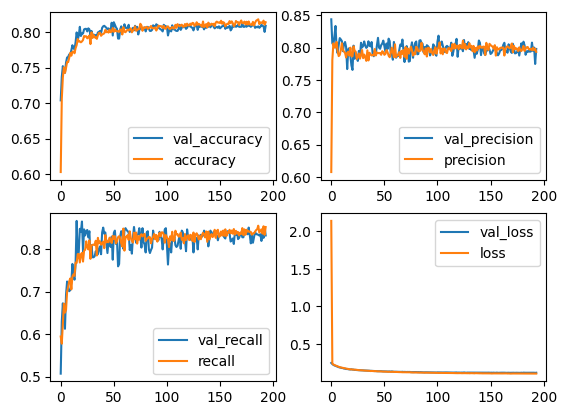

In [11]:
print(history.history.keys())
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(history.history['val_accuracy'])
axs[0, 0].plot(history.history['accuracy'])
axs[0, 0].legend(['val_accuracy', 'accuracy'])

axs[0, 1].plot(history.history['val_precision'])
axs[0, 1].plot(history.history['precision'])
axs[0, 1].legend(['val_precision', 'precision'])

axs[1, 0].plot(history.history['val_recall'])
axs[1, 0].plot(history.history['recall'])
axs[1, 0].legend(['val_recall', 'recall'])

axs[1, 1].plot(history.history['val_loss'])
axs[1, 1].plot(history.history['loss'])
axs[1, 1].legend(['val_loss', 'loss'])

In [12]:
score = model.evaluate(test_x, test_y)
print(score[0])
print(score[1])

55/55 [==============================] - 0s 3ms/step - loss: 0.1161 - accuracy: 0.7849 - precision: 0.7571 - recall: 0.8451
0.1161470040678978
0.784933865070343


In [16]:
train_x = train.iloc[:,:-1]
train_y = train.iloc[:,-1].astype(float)

test_x = test_df.iloc[:,:-1]
test_y = test_df.iloc[:,-1].astype(float)

ord_list = ['Cabin_number']
train_x, mean, scaler, encoder = encoding(train_x, ord_list)
train_x = fs(train_x, train_y)

test_x = preproc_val_test(test_x, mean, scaler, ord_list)

------ RoomService, FoodCourt, ShoppingMall, Spa, VRDeck ------
Persone con servizi nulli: 691
Persone con servizi nulli: 0
-------------------------- HomePlanet -------------------------
Le feature HomePlanet e Group sono correlate, con p-value7.383208949075836e-101
Numero di persone con HomePlanet nullo: 168
Numero di persone con HomePlanet nullo: 0
-------------------------- Destination ------------------------
Le feature Destination e Group sono correlate, con p-value0.00016495054761429579
Numero di persone con Destination nullo: 139
Numero di persone con Destination nullo: 0
------------------------------ Surname ------------------------
Le feature Surname e Group sono correlate, con p-value0.0
Numero di persone con Surname nullo: 159
Numero di persone con Surname nullo: 0
----------------------------- Age -----------------------------
Numero di persone con Age nullo: 148, di cui:
Persone sole: 87
Persone con famiglia che non spendono: 40
Persone con famiglia che spendono: 21
Nume

In [17]:
model = model_fn() 
model.compile(optimizer = keras.optimizers.Adam(learning_rate=lr_schedule), loss = 'binary_focal_crossentropy', metrics = ['accuracy', Precision(), Recall()])

history = model.fit(train_x, train_y,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE)

score = model.evaluate(test_x, test_y)


train_df = pd.concat([train_x, train_y], axis=1)
train_df.to_csv('datasets/train_titanic.csv', index=False)
test_df = pd.concat([test_x, test_y], axis=1)
test_df.to_csv('datasets/test_titanic.csv', index=False)

model.save('models/titanic_model')
model.save_weights('models/titanic_weights')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1024)              17408     
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)              

INFO:tensorflow:Assets written to: models/titanic_model/assets


55/55 [==============================] - 0s 2ms/step


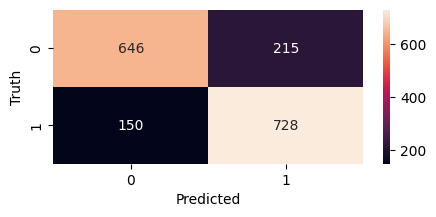

In [20]:
# stampare graficamente la matrice di confusione
from sklearn.metrics import confusion_matrix
y_pred = model.predict(test_x)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(test_y, y_pred)

import seaborn as sns
plt.figure(figsize=(5, 2))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()